<a href="https://colab.research.google.com/github/blessjal/blessjal/blob/main/Brain_Cancer_Detection_Using_Mobile_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [2]:
!wget https://www.dropbox.com/s/dtw18saps0231yn/BrainTumorData.zip?d1=0

--2021-06-28 03:11:23--  https://www.dropbox.com/s/dtw18saps0231yn/BrainTumorData.zip?d1=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/dtw18saps0231yn/BrainTumorData.zip [following]
--2021-06-28 03:11:23--  https://www.dropbox.com/s/raw/dtw18saps0231yn/BrainTumorData.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce6f27f5e183551ab65cecafaf2.dl.dropboxusercontent.com/cd/0/inline/BRQDIqdcBklsCDlbG4n9UAVA60rz_xEoye9hIHYfkZe1G3SaAlvY-x6ZJs9leEalRuyRhqMJaVbmv86qZ6LF-IhXvKUGWmlbkMm4EDtePOa_LFdRZnU70blzEi0TwW5_JBVdYb_r9X-GYm70EOjojj3B/file# [following]
--2021-06-28 03:11:23--  https://uce6f27f5e183551ab65cecafaf2.dl.dropboxusercontent.com/cd/0/inline/BRQDIqdcBklsCDlbG4n9UAVA60rz_xEoye9hIHYfkZe1G3SaAlvY-x6ZJs9leEalRuy

In [3]:
!unzip /content/BrainTumorData.zip?d1=0

Archive:  /content/BrainTumorData.zip?d1=0
   creating: BrainTumorData/Brain Tumor Data Set/
   creating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1).png  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1).tif  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (10).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (10).tif  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (100).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1000).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1001).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1002).JPG  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1003).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/

In [4]:
# count the number of images in each class
ROOT_DIR = "/content/BrainTumorData/Brain Tumor Data Set"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

In [5]:
number_of_images.items()

dict_items([('Healthey', 2087), ('Brain Tumor', 2513)])

## We will split the data such that 
* 70% for Training 
* 15% for Validation
* 15% for Testing


In [6]:
def dataFolder(path, split):
    
    if not os.path.exists("./"+path):
        os.mkdir("./"+path)

        for dir in os.listdir(ROOT_DIR):
            os.mkdir("./"+path+"/"+dir)

            for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir)), size=(math.floor(split*number_of_images[dir])-5), 
                                        replace=False):
                O = os.path.join(ROOT_DIR, dir, img)
                D = os.path.join("./"+path, dir)
                shutil.copy(O,D)
                os.remove(O)
    else:
        print(f'{path} folder exist')


In [7]:
dataFolder('train', 0.7)

In [8]:
dataFolder('val', 0.15)

In [9]:
dataFolder('test', 0.15)

# Preparing Data using Data Generator

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input

In [11]:
def preprocessingImages(path):
    """ 
    input: path
    output: Preprocessed images
    """
    image_data = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, preprocessing_function=preprocess_input, horizontal_flip=True)
    image = image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size=32, class_mode='binary')

    return image

In [12]:
path = "/content/train"
train_data = preprocessingImages(path)

Found 3209 images belonging to 2 classes.


In [13]:
train_data.class_indices

{'Brain Tumor': 0, 'Healthey': 1}

In [14]:
def preprocessingImages2(path):
    """ 
    input: path
    output: Preprocessed images
    """
    image_data = ImageDataGenerator(preprocessing_function=preprocess_input)
    image = image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size=32, class_mode='binary')

    return image

In [15]:
path = "/content/test"
test_data = preprocessingImages2(path)

Found 679 images belonging to 2 classes.


In [16]:
path = "/content/val"
val_data = preprocessingImages2(path)

Found 679 images belonging to 2 classes.


Early stopping and model checkpoint

# Model Training

In [17]:
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet, preprocess_input

In [18]:
base_model = MobileNet(input_shape=(224,224,3), include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [19]:
for layer in base_model.layers:
    layer.trainable = False

In [20]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [21]:
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)

model = Model(base_model.input, X)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [22]:
import keras
model.compile(optimizer='rmsprop', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose= 1)

mc = ModelCheckpoint(monitor='val_accuracy', filepath='./bestmdel.h5', verbose=1, save_best_only=True)

cb = [es, mc]

In [24]:
history = model.fit_generator(train_data, 
                         steps_per_epoch=8, 
                         epochs=30, 
                         validation_data=val_data, 
                         validation_steps=16, 
                         callbacks=cb)

Epoch 1/30
8/8 [==============================] - 53s 829ms/step - loss: 8.0787 - accuracy: 0.5727 - val_loss: 5.7273 - val_accuracy: 0.5781

Epoch 00001: val_accuracy improved from -inf to 0.57812, saving model to ./bestmdel.h5
Epoch 2/30
8/8 [==============================] - 5s 620ms/step - loss: 2.4377 - accuracy: 0.7370 - val_loss: 0.9030 - val_accuracy: 0.8457

Epoch 00002: val_accuracy improved from 0.57812 to 0.84570, saving model to ./bestmdel.h5
Epoch 3/30
8/8 [==============================] - 5s 609ms/step - loss: 2.2825 - accuracy: 0.7840 - val_loss: 0.5062 - val_accuracy: 0.9102

Epoch 00003: val_accuracy improved from 0.84570 to 0.91016, saving model to ./bestmdel.h5
Epoch 4/30
8/8 [==============================] - 5s 619ms/step - loss: 1.3551 - accuracy: 0.8111 - val_loss: 1.0939 - val_accuracy: 0.8594

Epoch 00004: val_accuracy did not improve from 0.91016
Epoch 5/30
8/8 [==============================] - 5s 634ms/step - loss: 0.7411 - accuracy: 0.8768 - val_loss: 0.3

In [25]:
model = load_model('/content/bestmdel.h5')

Model Accuracy

In [26]:
acc = model.evaluate_generator(test_data)[1]
print(f'The model accuracy is {acc*100} %')

The model accuracy is 94.25625801086426 %


In [27]:
h = history.history

h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

 Plotting graphical interpretation

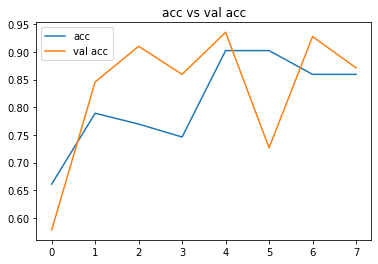

In [28]:
plt.plot(h['accuracy'], label='acc')
plt.plot(h['val_accuracy'], label='val acc')
plt.title('acc vs val acc')
plt.legend()

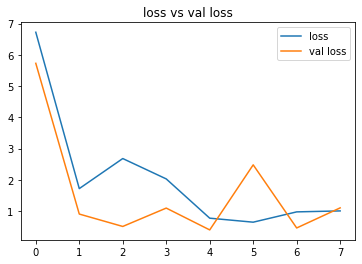

In [29]:
plt.plot(h['loss'], label='loss')
plt.plot(h['val_loss'], label='val loss')
plt.title('loss vs val loss')
plt.legend()

In [30]:
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array

In [48]:
path = "/content/BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (4).jpg"

img = image.load_img(path, target_size=(224,224))

i = image.img_to_array(img)
i = preprocess_input(i)
input_arr = np.array([i])
input_arr.shape


pred = np.argmax(model.predict(input_arr))
pred

if pred == 0:
    print('The MRI image is of BRAIN TUMOR')

else:
    print('The MRI image is of HEALTHY BRAIN')

The MRI image is of BRAIN TUMOR


In [57]:
path = "/content/BrainTumorData/Brain Tumor Data Set/Healthey/Not Cancer  (1461).jpg"

img = image.load_img(path, target_size=(224,224))

i = image.img_to_array(img)/255
i = preprocess_input(i)
input_arr = np.array([i])
input_arr.shape


pred = np.argmax(model.predict(input_arr))
pred

if pred == 0:
    print('The MRI image is of BRAIN TUMOR')

else:
    print('The MRI image is of HEALTHY BRAIN')

The MRI image is of BRAIN TUMOR


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'input image')

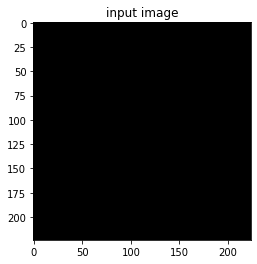

In [61]:
plt.imshow(input_arr[0])
plt.title('input image')